In [1]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
import skrf as rf # scikit-rf : object-oriented approach to microwave engineering

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 8  # increase the default image size 

Importing home-made classes.

In [5]:
import sys
sys.path.append('..')
from WEST_design.antenna.conjugate_t import ConjugateT
from WEST_design.antenna.resonant_loop import ResonantDoubleLoop
from WEST_design.antenna.topica import TopicaResult

# Importing the full-wave solutions

We import the three devices of our electric circuit: the bridge, the impedance transformer and the window. As the default frequency range defined in skrf is the GHz, we set the frequency unit to MHz (this is only in order to have nicer plot after).  

In [5]:
bridge = rf.Network('../WEST_design/data/Sparameters/WEST/WEST_ICRH_bridge.s3p', f_unit='MHz')
impedance_transformer = rf.Network('../WEST_design/data/Sparameters/WEST/WEST_ICRH_impedance-transformer.s2p', f_unit='MHz')
window = rf.Network('../WEST_design/data/Sparameters/WEST/WEST_ICRH_window.s2p', f_unit='MHz')

In [6]:
print(bridge)
print(impedance_transformer)
print(window)

3-Port Network: 'WEST_ICRH_bridge',  40.0-60.0 MHz, 201 pts, z0=[  5.68450244-0.00430942j  13.68468209-0.00334742j  13.68647445-0.0033458j ]
2-Port Network: 'WEST_ICRH_impedance-transformer',  40.0-60.0 MHz, 201 pts, z0=[ 40.02030696-0.00599664j   5.89109797-0.00429714j]
2-Port Network: 'WEST_ICRH_window',  40.0-60.0 MHz, 201 pts, z0=[ 29.73896504+0.j  40.00951417+0.j]


# TOPICA Matrix

Here we connect a TOPICA coupling matrix to two resonant loops. Pay attention to the way TOPICA indexes the straps. 
$$\begin{matrix}
2 & | & 1 \\
4 & | & 3
\end{matrix}$$
cf figure below
<img src="./figures/network.png"/>

### Parameters

In [7]:
def TOPICA_plasma(s4p_filename, frequency):
    '''
    Returns a skrf Network from a Touchstone file which contains TOPICA plasma simulation.
    
    The S-parameters are repeated for all frequencies for compatibility with skrf.
    '''
    ntwk = rf.Network(s4p_filename)
    ntwk.frequency = frequency
    ntwk.s = np.tile(ntwk.s, (len(frequency), 1, 1)) # could use to_frequency()
    ntwk.z0 = ntwk.z0#np.tile(ntwk.z0, (len(frequency),1))
    return ntwk

In [8]:
f_match = 55e6 # matching frequency
Z_match = [30+1j*0, 30+1j*0] # matching impedance 
power_in = [1, 1] # input wave powers [watts]
phase_in = [0, pi] # input wave phases [radians]
plasma_profile_nb = 3 # 1 to 8 for Tore Supra L-mode plasma density profiles measured in 2007.

filename = '../WEST_design/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile{}.s4p'\
            .format(str(int(plasma_profile_nb)))
print(filename)

../WEST_design/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile3.s4p


In [12]:
plasma_TOPICA = TOPICA_plasma(filename, bridge.frequency)

CT1 = ConjugateT(bridge, impedance_transformer, window)
CT2 = ConjugateT(bridge, impedance_transformer, window) 

RDL = ResonantDoubleLoop(CT1, CT2, plasma_TOPICA) 

In [15]:
sol_TOPICA = RDL.match(power_in, phase_in, f_match, Z_match)

False [  7.77750439e+01   6.49207580e+01  -9.10614189e+06   6.47483383e+01]
Bad solution found (out of range capacitor) ! Re-doing...
False [  6.51057380e+01   1.05080416e+02   5.88670369e+04  -8.50737761e+04]
Bad solution found (out of range capacitor) ! Re-doing...
Bad solution found (out of range capacitor) ! Re-doing...
False [  2.09357091e+12   6.45440248e+01  -1.67924399e+13   6.51109076e+01]
Bad solution found (out of range capacitor) ! Re-doing...
Bad solution found (out of range capacitor) ! Re-doing...
False [ -2.06583748e+05   6.43112247e+01   7.75292955e+01   6.51761641e+01]
Bad solution found (out of range capacitor) ! Re-doing...
False [  6.46016282e+01  -8.33890707e+05  -9.16169203e+03   6.45718647e+01]
Bad solution found (out of range capacitor) ! Re-doing...
Bad solution found (out of range capacitor) ! Re-doing...
True [ 77.45014589  64.60128986  77.36813287  64.70465708]
Solution found : C=[ 77.45014589  64.60128986  77.36813287  64.70465708]


For the same set of capacitor values found, we vary the plasma loads (from plasma reference indexes 1 to 8) and plot scattering parameters and VSWR

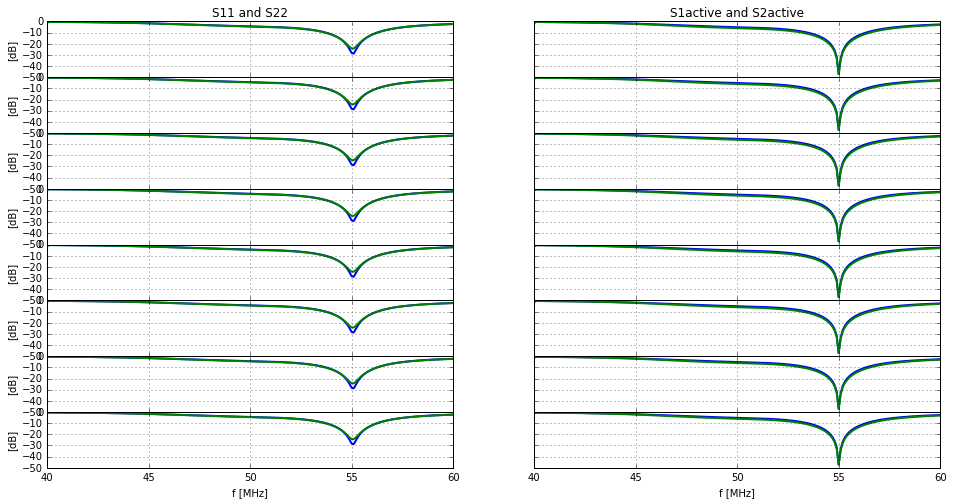

In [16]:
# 8x2=16 subplots : left column are Sii and right are active Si
f, axarr = plt.subplots(8, 2, sharex=True, sharey=True)
# make subplots clSose to each other and hide x ticks for all but bottom plots.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-2]], visible=False)
# titles and axes labels
axarr[0,0].set_title('S11 and S22')
axarr[0,1].set_title('S1active and S2active')
axarr[7,0].set_xlabel('f [MHz]')
axarr[7,1].set_xlabel('f [MHz]')
# let's go Marco !
for id in range(8):
    RDL.plasma = TOPICA_plasma(\
            '../WEST_design/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile{}.s4p'.format(int(plasma_profile_nb)), \
            bridge.frequency)
    # S11 and S22
    axarr[id, 0].plot(RDL.get_f()/1e6, RDL.get_network().s_db[:,0,0], lw=2)
    axarr[id, 0].plot(RDL.get_f()/1e6, RDL.get_network().s_db[:,1,1], lw=2)
    axarr[id, 0].grid(True)
    axarr[id, 0].set_ylabel('[dB]' )
    
    # Sactive1 and Sactive2
    Sact = RDL.get_s_active(power_in, phase_in)
    axarr[id, 1].plot(RDL.get_f()/1e6, 20*np.log10(np.abs(Sact[:,0])), lw=2)
    axarr[id, 1].plot(RDL.get_f()/1e6, 20*np.log10(np.abs(Sact[:,1])), lw=2)
    axarr[id, 1].grid(True)
    

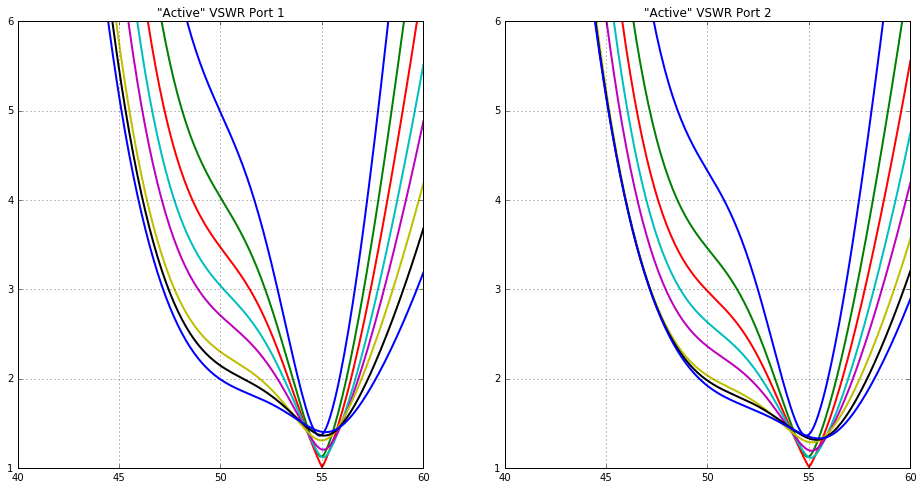

In [17]:
for id in range(1, 9):    
    RDL.plasma = TOPICA_plasma(\
                               '../WEST_design/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile{}.s4p'.format(id),\
                               bridge.frequency)
    VSWR_active = RDL.get_vswr_active(power_in, phase_in)

    subplot(1,2,1)
    plot(RDL.get_f()/1e6, VSWR_active[:,0] , lw=2)
    axis([40,60,1,6])
    grid('on')
    title('"Active" VSWR Port 1')
    
    subplot(1,2,2)
    plot(RDL.get_f()/1e6, VSWR_active[:,1] , lw=2)    
    axis([40,60,1,6])
    grid('on')
    title('"Active" VSWR Port 2')



# Sweep over plasma profiles

At a given frequency, we sweep over the eight plasma profiles. For each plasma profile, we seek for the match point and store the match points found. The match points vs the plasma profile are then plot.  

In [18]:
f_match = 55e6 # matching frequency
Z_match = [30+1j*0, 30+1j*0] # matching impedance 
power_in = [1, 1] 
phase_in = [0, pi]

In [19]:
CT1 = ConjugateT(bridge, impedance_transformer, window)
CT2 = ConjugateT(bridge, impedance_transformer, window) 
C_vs_plasma_profile = np.zeros((8,4)) # 8 profiles, 4 capacitor values

for id_profile in range(1, 9):
    filename = '../WEST_design/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile{}.s4p'.format(id_profile)
    print('========== '+filename)
    plasma_TOPICA = TOPICA_plasma(filename, bridge.frequency)
    RDL = ResonantDoubleLoop(CT1, CT2, plasma_TOPICA) 

    sol_TOPICA = RDL.match(power_in, phase_in, f_match, Z_match)
    C_vs_plasma_profile[id_profile-1, :] = sol_TOPICA.x
    

========== ../WEST_design/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile1.s4p
False [  7.54872729e+01   6.49539763e+01   1.04343460e+09   6.36930232e+01]
Bad solution found (out of range capacitor) ! Re-doing...
False [  6.36440915e+01   1.50132316e+03  -2.84484038e+06   6.34899961e+01]
Bad solution found (out of range capacitor) ! Re-doing...
Bad solution found (out of range capacitor) ! Re-doing...
False [   63.54887127 -7123.21450689   246.37674184    63.84472853]
Bad solution found (out of range capacitor) ! Re-doing...
Bad solution found (out of range capacitor) ! Re-doing...
False [    84.39016654     64.57163177 -11980.15986943     64.94371679]
Bad solution found (out of range capacitor) ! Re-doing...
False [ 82.29420432  26.57961371  51.97126928  47.69972915]


KeyboardInterrupt: 

In [ ]:
C_vs_plasma_profile/1e-12

In [ ]:
plot(range(1,9), C_vs_plasma_profile/1e-12, 'o', markersize=14 )
grid()
title('Capacitor values (1st solution found) vs plasma profile \n' 
      'f_match='+str(f_match/1e6)+' MHz \n'
      'Excitation: a='+str((power_in, phase_in)),  fontsize=16 )
xlabel('L-Mode Plasma profile',  fontsize=16)
ylabel('Capacitor value [pF]',  fontsize=16)
legend(('C1H', 'C1B' , 'C2H', 'C2B'), loc='best')
axis([0.2, 8.8, 20, 100])

# Currents and Voltages at capacitors

In this section we explore the currents and voltages at the capacitors for a prescribed input. 

In [ ]:
I, V = RDL.get_currents_and_voltages(power_in, phase_in)

In [ ]:
subplot(211)
plot(RDL.get_f()/1e6, abs(I), lw=2)
grid(True)
xlabel('f [MHz]')
ylabel('Capacitor Currents [kA]')
subplot(212)
plot(RDL.get_f()/1e6, abs(V), lw=2)
grid(True)
xlabel('f [MHz]')
ylabel('Capacitor Voltages [kV]')